In [439]:
import copy
import random
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import sys

class Node:

    def __init__(self, _id, x, y):
        self.x = x
        self.y = y
        self._id = _id
        # self.group = group
    
    
class Group:
    
    def __init__(self, _id, nodes):
        self._id = _id
        self.nodes = nodes
        # self.demand = demand
    
    
class Graph:

    def __init__(self, graph_dict={}):
        if (isinstance(graph_dict, Graph)):
            self.__graph_dict = copy.deepcopy(graph_dict.__graph_dict)
        else:
            self.__graph_dict = graph_dict

    def vertices(self):
        return list(self.__graph_dict.keys())

    def edges(self):
        return self.__generate_edges()

    def add_vertex(self, vertex):
        if vertex not in self.__graph_dict:
            self.__graph_dict[vertex] = []

    def add_edge(self, edge, bidirectional=True):
        (vertex1, vertex2, cost) = edge
        self.add_vertex(vertex1)
        self.add_vertex(vertex2)
        self.__add_edge_no_repetition(vertex1, vertex2, cost)
        if bidirectional:
            self.__add_edge_no_repetition(vertex2, vertex1, cost)

    def direct_cost(self, vertex1, vertex2):
        list_v1 = self.__graph_dict[vertex1]
        for (v, cost) in list_v1:
            if v == vertex2:
                return cost
        else:
            return float('inf')

    def __add_edge_no_repetition(self, v1, v2, cost):
        list_v1 = self.__graph_dict[v1]
        for i, (v, _) in enumerate(list_v1):
            if v == v2:
                list_v1[i] = (v2, cost)
                break
        else:
            list_v1.append((v2, cost))

    def __generate_edges(self):
        edges = []
        for vertex in self.__graph_dict:
            for (neighbour, cost) in self.__graph_dict[vertex]:
                if (neighbour, vertex) not in edges:
                    edges.append((vertex, neighbour, cost))
        return edges

    def __str__(self):
        return 'Vertices: {0}\nEdges: {1}'.format(sorted(self.vertices()), sorted(self.edges()))

    
class Car:
    
    def __init__(self, _id, total_cap):
        self._id = _id
        self.total_cap = total_cap
        self.grupos = []
        self.cur_cap = 0
    
    
    
inputNome = sys.argv[2]
outputNome = sys.argv[4]
arquivoLeitura = open(inputNome,'r')
arquivoEscrita = open(outputNome, 'a')
flagGroups = False
flagNodes = False
flagDemand = False
nodes = []
grupos = []
dimension = None
vehicles = None
ewt = None
capacity = None
sets_qtt = None
set_demands = []

for linha in arquivoLeitura:
    if not ('EOF' in linha):
        if 'DIMENSION' in linha:
            novo = list(linha.split())
            dimension = novo[2]

        if 'VEHICLES' in linha:
            novo = list(linha.split())
            vehicles = int(novo[2])

        if 'SETS' in linha:
            novo = list(linha.split())
            sets_qtt = novo[2]

        if 'EDGE_WEIGHT_TYPE' in linha:
            novo = list(linha.split())
            ewt = novo[2]

        if 'CAPACITY' in linha:
            novo = list(linha.split())
            capacity = int(novo[2])

        if (flagDemand):
            novo = list(map(int, linha.split()))
            grupos[novo[0] - 1].demand = novo[1]
            set_demands.append(int(novo[1]))

        if 'DEMAND_SECTION' in linha:
            flagGroups = False
            flagDemand = True

        if(flagGroups): #criando grupos de nós e salvando
            novo = list(map(int, linha.split()))
            grupo = []
            id_aux = None
            for i in range(len(novo)):
                if i == 0:
                    id_aux = novo[i]
                else:
                    if novo[i] != -1:
                        grupo.append(novo[i])
                
            x = Group (novo[0], grupo) # novo[0] = 'id' 
            grupos.append(x)

        if 'SET_SECTION' in linha:
            flagNodes = False
            flagGroups = True

        if(flagNodes): #criando nós e salvando 
            novo = list(map(int, linha.split()))
            x = Node(novo[0], novo[1], novo[2])
            nodes.append(x)

        if 'NODE_COORD_SECTION' in linha:
            flagNodes = True
    
        
def euclidian_distance (x1, x2, y1, y2):
    return math.sqrt(((x2-x1) ** 2) + ((y2-y1) ** 2))

edges = []
g = Graph({})

for n in nodes:
    for v in nodes:
        if (n._id != v._id):
            edges.append((n._id, v._id, euclidian_distance(n.x, v.x, n.y, v.y)))
            g.add_edge((n._id, v._id, euclidian_distance(n.x, v.x, n.y, v.y)))


def return_group(v, groups):
    group = None
    for c in groups:
        if v in c.nodes:
            group = c
            break
    return group

nodes_dict = {}
for n in nodes:
    nodes_dict.update({n._id : (n.x, n.y)})
    n.group = return_group(n._id, grupos)

In [440]:
def retrieve_node_by_id (node_id, nodes):
    for n in nodes:
        if n._id == node_id:
            return n

def closest_vertex_neighbor(vertex, edges, groupList, cur_cap, capacity):
    closest_cost = (-1)
    closest_edge = None
    v1_group = None
    v2_group = None
    
    temp = cur_cap
    
    for e in edges:
        (v1,v2,cost) = e
        v1_group = return_group(v1, groupList)
        v2_group = return_group(v2, groupList)
    
        if v1 == vertex._id  and v2_group != None and v1_group != v2_group and (v2_group.demand/cost) > closest_cost:
            if(v2_group.demand + temp <= capacity):
                closest_edge = e
                closest_cost = (v2_group.demand/cost)
                temp = cur_cap + v2_group.demand
                

    return closest_edge

def nearest_neighbor_tour(G, edges, groupList, nodes, car):
    
    capacity = car.total_cap
    random_v = retrieve_node_by_id(1, nodes)
    path = []
    
    cur_cap = 0
    print (str(random_v._id) + "-", end = "")
    
    while edges and groupList and closest_vertex_neighbor(random_v, edges, groupList, cur_cap, capacity) != None and cur_cap <= capacity:
        closest_edge = closest_vertex_neighbor(random_v, edges, groupList, cur_cap, capacity)
        (v1, v2, cost) = closest_edge
        bidirecional = (v2, v1, cost)
        edges.remove(closest_edge)
        edges.remove(bidirecional)
        random_v = retrieve_node_by_id(v2, nodes)
        groupList.remove(random_v.group)
        cur_cap = cur_cap + random_v.group.demand
        path.append((v1,v2,cost))
        print (str(v2) + "-", end = "")

    print (initial_vertex._id)
    path.append((random_v._id, initial_vertex._id, G.direct_cost(random_v._id, initial_vertex._id)))
    car.cur_cap = cur_cap
    return path

def total_demand_in_groups (groups):
    total = 0
    for c in groups:
        total = c.demand + total
        
    return total



In [441]:
def smallest_partition_index(sets):
    rIndex = -1
    smallest = float('inf')
    for s in sets:
        if total_demand_in_groups(s) < smallest:
            smallest = total_demand_in_groups(s)
            rIndex = sets.index(s)
            
    return rIndex
    

def find_partition(groups, k):
    
    sets = []
    
    for i in range(k):
        sets.append([])
        
    for n in sorted(groups, key=lambda x: x.demand, reverse=True):
        index = smallest_partition_index(sets)
        sets[index].append(n)
        
        
    return sets



In [454]:
def print_graph (nodes_dict, edges):
    G = nx.Graph()
    
    for e in edges:
        G.add_edge(e[0], e[1], weight = e[2])
        
    nx.draw(G, pos, with_labels = True)
    plt.show()

In [443]:
vehicles_iterator = 0

cars = []
total_demand = 0

final_groups = []

total_demand = total_demand_in_groups (grupos)
    


for i in range(vehicles):
    x = Car(i+1, capacity)
    cars.append(x)

time_start = time.perf_counter()

if total_demand == vehicles * capacity:
    
    partitions = find_partition(grupos, vehicles)
    
    for v in range(vehicles):
        cars[v].grupos = partitions.pop()
    

while vehicles_iterator < vehicles:
    print ("Veículo: " + str(cars[vehicles_iterator]._id))
    if (cars[vehicles_iterator].grupos):
        cars[vehicles_iterator].path = nearest_neighbor_tour(g, edges, cars[vehicles_iterator].grupos, nodes, cars[vehicles_iterator])
    else:
        cars[vehicles_iterator].path = nearest_neighbor_tour(g, edges, grupos, nodes, cars[vehicles_iterator])
    print ("FINAL CAPACITY: " + str(cars[vehicles_iterator].cur_cap))
    vehicles_iterator = vehicles_iterator + 1
    print ("========================")
        
        
time_elapsed = (time.perf_counter() - time_start)
bkv = 0
for c in cars:
    for e in c.path:
        (v1, v2, cost) = e
        bkv = bkv + cost
        
print (bkv)
print (time_elapsed)

arquivoLeitura.close()
arquivoEscrita.(inputNome + " " + str(bkv) + " " + str(time_el))

Veículo: 1
1-13-17-15-7-22-5-9-6-1
FINAL CAPACITY: 100
Veículo: 2
1-8-16-11-23-29-3-21-30-1
FINAL CAPACITY: 100
793.4194475333959
0.05707708199042827


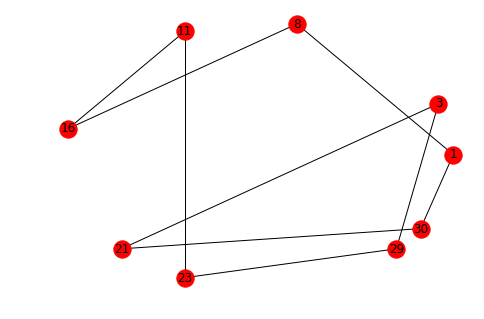

In [455]:
print_graph(nodes_dict, cars[1].path)

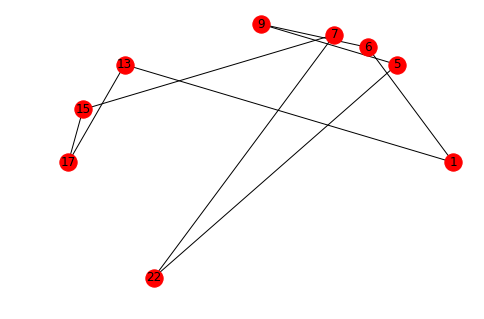

In [456]:
print_graph(nodes_dict, cars[0].path)